<a href="https://colab.research.google.com/github/christianeloysio/Data_Science/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credict Card Fraud Detection

One of the top concerns for financial institutions is credit card fraud. Nowadays, Credit card transactions correspond to [26%](https://olhardigital.com.br/en/2021/04/06/internet-e-redes-sociais/operacoes-com-cartoes-de-credito-correspondem-a-26-das-fraudes-digitais-no-brasil/) of digital fraud in Brazil, for example.

<p align=center>
<img src="https://riotimesonline.com/wp-content/uploads/2021/02/Card-Fraud.jpeg" width="60%"></p>

For this reason, investment in fraud detection through Artificial Intelligence is growing every year, representing a great opportunity in *Data Science*. With large volumes of data as a historical basis, a machine learning algorithm that is slightly better than the previous ones represents millionaire savings. 

Using public data available on credit card transactions, I will show how we can train a Machine Learning Model for credit card fraud detection.



## Importing Data

The dataset is originated from European Credit Card companies. The dataset contains financial transactions for a two-day period, where 492 frauds were detected among nearly 290,000 transactions. As we can already notice, this is an unbalanced dataset, where fraud accounts for only 0.17% of the total.

Another detail is that the *features* are all numerical and have been mischaracterized (due to privacy and security issues). Thus, the column names are represented by $ [V1, V2, V3\ dots, V28] $ 

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[The original data page](https://www.kaggle.com/mlg-ulb/creditcardfraud) reports that the variables were transformed using the *Principal Component Analysis* (PCA). 

PCA allows the reduction of dimensionality while maintaining as much information as possible. The algorithm finds a new set of features - so-called **components**. In this dataset, the components left after the PCA are the $ [V1, V2, V3\ dots, V28] $.

## Importing the libraries 

Let´s first import all the libraries we will use:

In [52]:
!pip install -q scikit_plot

In [53]:
# importing the libraries that we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#setting the style to seaborn
sns.set_style("dark")

Let´s import the data we will use in the analysis and split it into training and test data.

In [29]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importing the dataset to a dataframe
df = pd.read_csv(file_path)
print("Original Dataset dimensions:", df.shape)

#splitting test data
test = df.sample(frac=0.15, random_state=0)
df = df.drop(test.index)

print("Train data dimensions: ", df.shape)
print("Test data dimensions: ", test.shape)

Original Dataset dimensions: (284807, 31)
Train data dimensions:  (242086, 31)
Test data dimensions:  (42721, 31)


As seen above, we separated 15% of the data to test the model, which we will do after training it. The Original dataset contains 284807 entries, in 31 different variables.

With the data as a DataFrame structure, let´s dive right into an exploratory analysis to understand it in more depth.

## Exploratory Data Analysis
 Let´s check the first entries of the dataset and the statistical summary of it:

In [30]:
#Checking the first entries for the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
#checking the statistical summary for the dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94857.597379,0.001456,-0.000800,-0.001004,0.000647,-0.000986,-0.001196,-0.000033,-0.000416,-0.000725,0.000813,-0.001191,-0.000572,0.000072,0.000397,0.000245,0.000511,0.000385,-0.000521,0.000345,0.001813,-0.000015,0.000606,-0.000482,0.000199,0.000048,-0.000269,-0.000727,0.000065,88.612429,0.001727
std,47490.660832,1.956513,1.654883,1.514580,1.417228,1.366284,1.326879,1.223095,1.199718,1.099350,1.089895,1.020427,0.998089,0.996738,0.957170,0.915073,0.875791,0.849826,0.837399,0.814400,0.763759,0.734189,0.726284,0.629651,0.605150,0.521574,0.482084,0.401490,0.327734,247.655020,0.041517
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-25.222345,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54234.000000,-0.920406,-0.598659,-0.893374,-0.848236,-0.693615,-0.769025,-0.553805,-0.208857,-0.645058,-0.534916,-0.764086,-0.406465,-0.649972,-0.425694,-0.583536,-0.467684,-0.484121,-0.499053,-0.456331,-0.211369,-0.228492,-0.542962,-0.161941,-0.354494,-0.316853,-0.327387,-0.070744,-0.052903,5.662500,0.000000
50%,84747.000000,0.019230,0.064567,0.177607,-0.018959,-0.054544,-0.274310,0.040344,0.022160,-0.051370,-0.092078,-0.034728,0.138776,-0.013510,0.050826,0.048587,0.067503,-0.065976,-0.004100,0.003691,-0.062290,-0.028987,0.007162,-0.011175,0.040764,0.017175,-0.052337,0.001131,0.011209,22.000000,0.000000
75%,139362.000000,1.316034,0.803174,1.026561,0.743691,0.611455,0.397688,0.570104,0.327186,0.597195,0.456105,0.738961,0.617590,0.663700,0.493601,0.649324,0.523874,0.399821,0.500078,0.459794,0.133355,0.187064,0.529814,0.147358,0.439320,0.350795,0.241214,0.090776,0.078234,77.580000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,7.059132,9.207059,5.041069,5.572113,39.420904,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Although the variables were transformed at a Principal Component Analysis, leaving all the columns normalized,  two columns have different dimensions. These columns are:

* `Time` - Number of seconds elapsed between this transaction and the first transaction in the dataset

* `Amount` - Transaction amount

Besides that, we have the variable `Class` representing if the transaction is fraudulent or not:

* 0 - Normal Transaction
* 1 - Fraudulent Transaction

Let´s now check if the dataset contains missing values:

In [32]:
#Calculating the column with the most null entries
df.isnull().sum().max()

0

Since we do not have any missing values, let´s analyze the number of entries for each class:

0    241668
1       418
Name: Class, dtype: int64

Frauds represents 0.17% of the dataset 



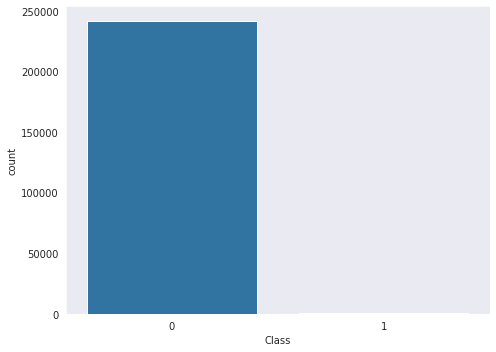

In [33]:
#Checking the number of entries per different classes
print(df.Class.value_counts())

print("\nFrauds represents {}% of the dataset \n".format(round(df[df.Class == 1].shape[0]*100/df.shape[0],2)))

fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(x="Class", data=df, ax=ax)
plt.tight_layout();

As previously stated, the dataset is extremely unbalanced. To enhance the results of our model we will have to take further action regarding this.

Let's now check the distribution for the variable `Time` in normal and fraudulent transactions:

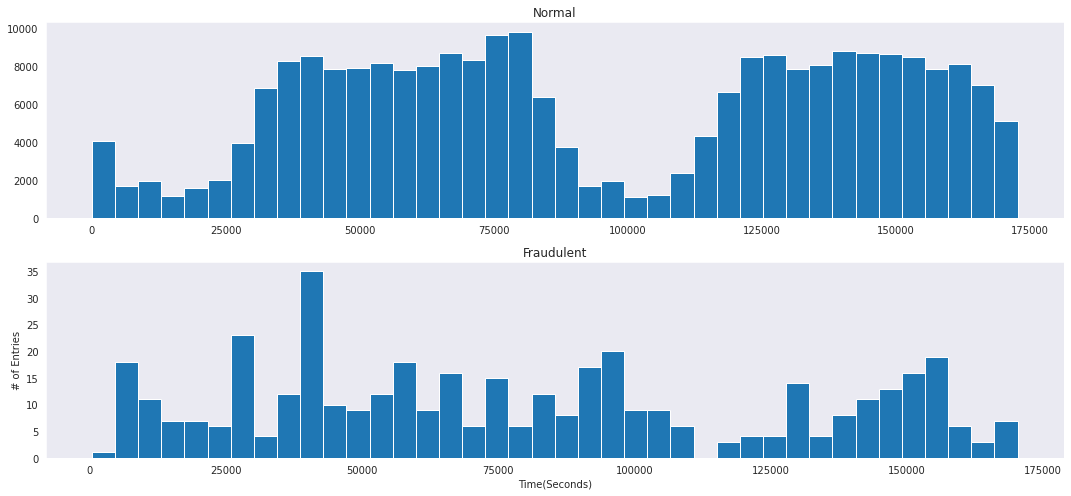

In [66]:
#Distirbution for "Time" per class

n_bins=40

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,7))

df[df.Class == 0].Time.hist(ax=ax1, bins=n_bins, grid=False)
ax1.set_title("Normal")

df[df.Class == 1].Time.hist(ax=ax2, bins=n_bins, grid=False)
ax2.set_title("Fraudulent")
ax2.set_xlabel("Time(Seconds)")
ax2.set_ylabel("# of Entries")

plt.tight_layout()

The difference in the number of entries may be explained by the different periods of the day, as day and night, when the number of transactions vastly differs.

Plotting a boxplot for the `Amount` variable in normal and fraudulent transactions:

In [35]:
#Calculating the superior limit for Amount Variable
q3 = df[df.Class == 1].Amount.quantile(.75)
q1 = df[df.Class == 1].Amount.quantile(.25)
IQR = q3 - q1

sup_limit = q3 + 1.5*IQR

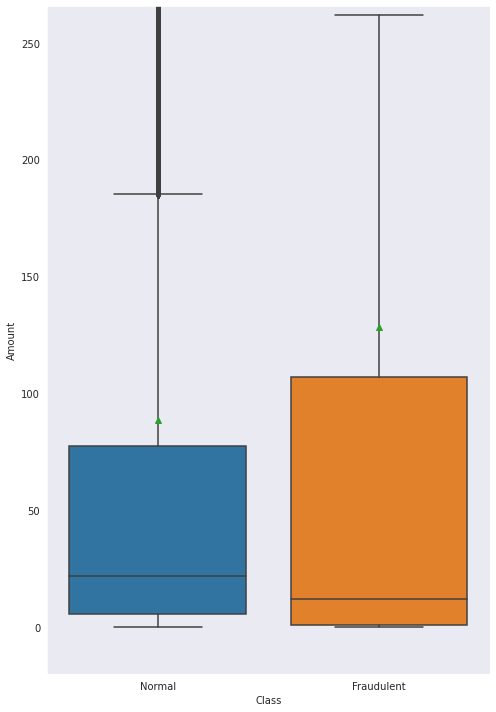

In [36]:
#plottig the boxplot for the the normal and fraudulent distibution
fig, ax = plt.subplots(figsize=(7,10))
sns.boxplot(x="Class", y="Amount", data=df, ax=ax, showmeans=True)
ax.set_ylim(-20, sup_limit)
ax.set_xticklabels(["Normal", "Fraudulent"])

plt.tight_layout()

Although the median is lower for the fraudulent transactions (represented by the black line inside each box), the mean (represented by the green triangle) is higher for fraudulent transactions than for normal ones.

We can also plot a density plot for each variable, separating fraudulent and normal transactions. Here, we are searching for variables that are significantly different for normal and fraudulent transactions:

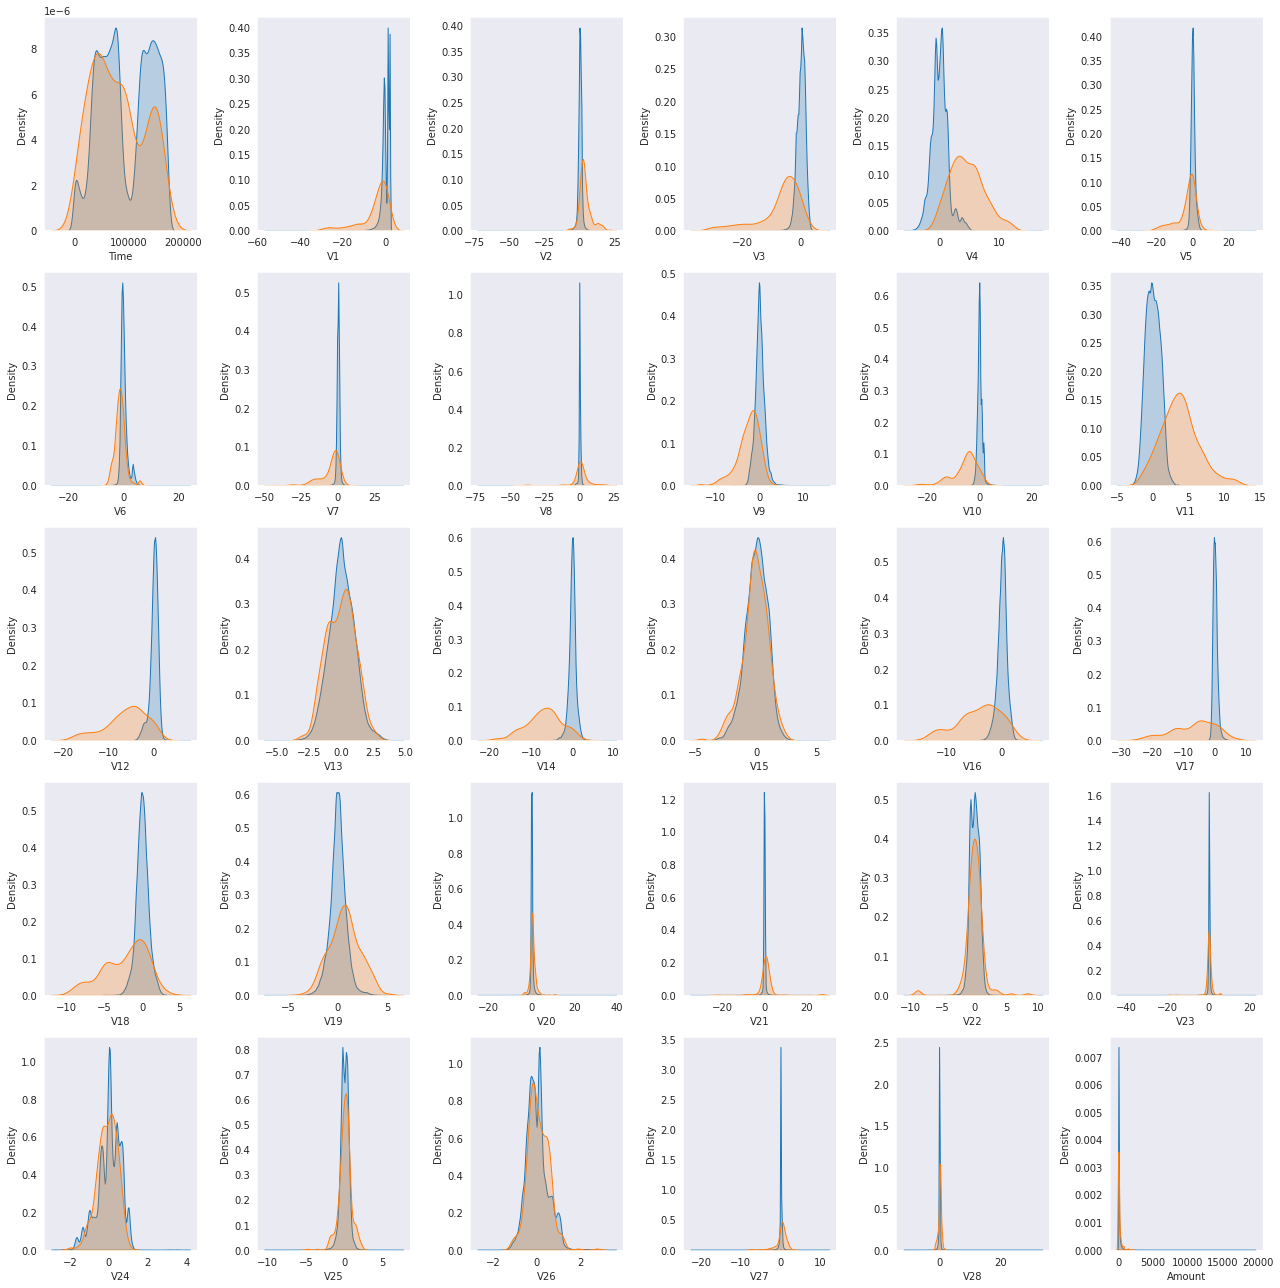

In [37]:
#plotting the density plot

columns_names = df.drop(labels=["Class"], axis=1).columns

df_normal = df[df.Class == 0]
df_fraud = df[df.Class == 1]

fig, ax = plt.subplots(nrows=5,ncols=6, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0

for col in columns_names:
  idx+=1
  plt.subplot(5,6,idx)
  sns.kdeplot(df_normal[col], label = "Normal", shade=True)
  sns.kdeplot(df_fraud[col], label = "Fraud", shade=True)

plt.tight_layout()

Some variables as `V14` and `V4` have pretty different behavior for the two classes.

After the initial exploratory analysis we can  state that:

* The variables `Time` and `Amount` are not normalized and will need to be transformed before training the model.
* The dataset is extremely unbalanced, representing a challenge for the analysis.
* The mean amount for fraudulent transactions is higher than the normal transaction mean amount.
* Some variables, as `V14` and `V4`, have a clear different behavior for normal and fraudulent transactions.

Based on that, we can now prepare the data before training the model.


## Preparing the data

First, we will normalize the `Time` and `Amount` variables. Since their dimensions are different from all the other variables, our model will be biased by these columns if we don't normalize them.

In [38]:
#normalizing "Amount" and "Time" variables
df_copy = df.copy()


std_scaler = StandardScaler()
df_copy["std_amount"] = std_scaler.fit_transform(df_copy.Amount.values.reshape(-1,1))
df_copy["std_time"] = std_scaler.fit_transform(df_copy.Time.values.reshape(-1,1))

df_copy.drop(["Time","Amount"], axis=1, inplace=True)

In [39]:
#checking the first entries
df_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


Now let´s split the data into training and validation data:

In [40]:
#splitting the dataset into train and validation
np.random.seed(2)
X = df_copy.drop("Class", axis=1)
y = df_copy["Class"]

X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle=True, stratify=y)

Last but not least, since the fraudulent transaction only accounts for 0,17% of the dataset, we should balance the dataset to have better results with our models.

 Among others, there are two ways in which we can solve this problem:

* **Over Sampling** - Creates new entries for the minority class based on the existing samples.
* **Under Sampling** - Randomly deletes entries for the majority class.

Here we will choose the under sampling method and apply it to the data:

In [41]:
#Balancing the dataset
rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Let´s visualize the new number of entries for fraudulent and normal transactions:

1    313
0    313
dtype: int64


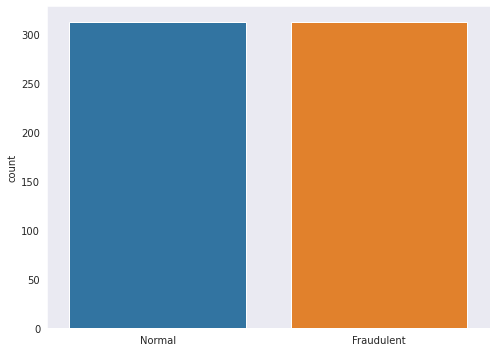

In [42]:
#Plotting balanced values
print(pd.Series(y_rus).value_counts())

fig, ax = plt.subplots(figsize=(7,5))

sns.countplot(x=y_rus, ax=ax)
ax.set_xticklabels(labels=["Normal","Fraudulent"])

plt.tight_layout()

Now we have the same number for fraudulent and normal transactions. 
To better understand the influence of unbalanced data, let´s plot a correlation matrix for the balanced and unbalanced dataset:

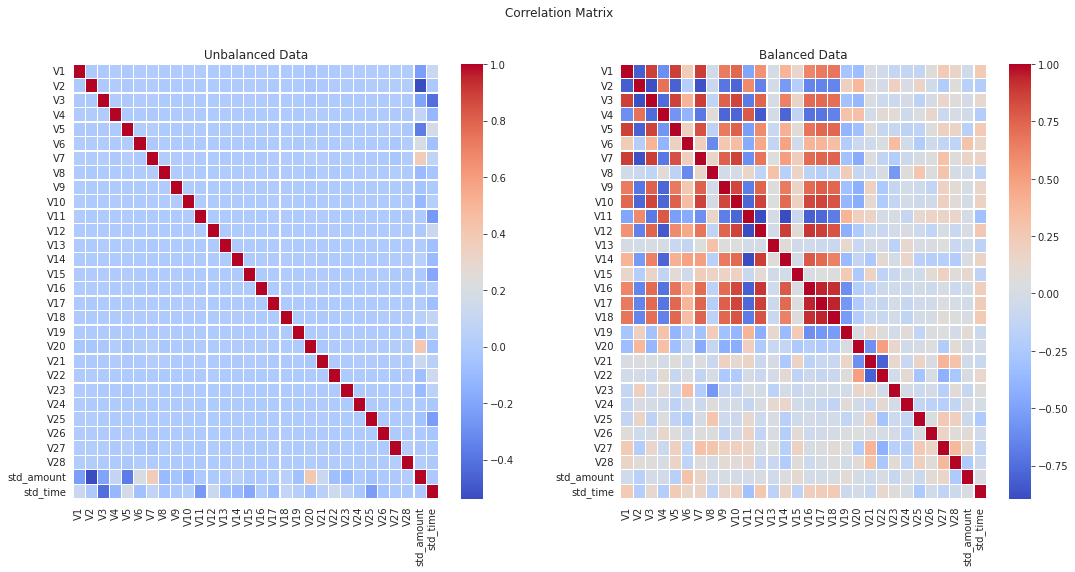

In [59]:
#plotting the correlation matrix for unbalanced and balanced data

imb_corr = X_train.corr()
corr = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
fig.suptitle("Correlation Matrix")

sns.heatmap(corr, ax=ax[1], cmap="coolwarm", linewidths=.1,
            xticklabels=imb_corr.columns, yticklabels=imb_corr.columns)
ax[1].set_title("Balanced Data")

sns.heatmap(imb_corr, ax=ax[0], cmap="coolwarm", linewidth=.1)
ax[0].set_title("Unbalanced Data")

plt.show()

We can find better correlations when the dataset is balanced, as demonstrated above.

With our data ready, we can choose the model and train it with our data.

## Machine Learning Models      

To better choose our model, we will train two models that use different algorithms to classify the data: **Logistic Regression** and **Decision Tree Classifier**. Afterward, we will analyze which model better classifies news transactions.

Let´s first build the Logistic Regression model:

In [44]:
#Building the first model using Logisitic Regression
lr_model = LogisticRegression()

lr_model.fit(X_rus, y_rus)

y_pred = lr_model.predict(X_val)

Let´s check some metrics for our first model, using our validation data:

Classification Report for Logisitic Regression Model: 

               precision    recall  f1-score   support

           0     0.9998    0.9726    0.9860     60417
           1     0.0537    0.8952    0.1012       105

    accuracy                         0.9724     60522
   macro avg     0.5267    0.9339    0.5436     60522
weighted avg     0.9982    0.9724    0.9845     60522

ROC Curve: 

 0.9339 



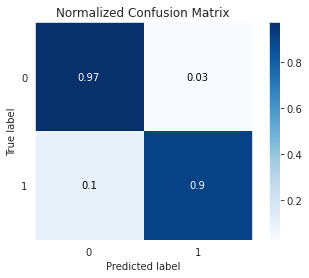

In [45]:
#Checking the metrics for the first model
print("Classification Report for Logisitic Regression Model: \n\n", classification_report(y_val, y_pred, digits=4))

#ROC
print("ROC Curve: \n\n", round(roc_auc_score(y_val, y_pred),4), "\n")

#plotting the confusion matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True);

As we can visualize, the accuracy for the first model is 0.97, which means that *among the total number of predictions, 97% of them were correct*. As the confusion matrix shows, the model correctly predicted 90% of the fraudulent transactions and 97% of the normal transactions.

Let's now train a model using the Decision Tree Classifier algorithm:

In [46]:
#Building other model using Decision Tree Classifier

tree_depth = 4

dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=tree_depth)

dt_model.fit(X_rus, y_rus)

y_pred = dt_model.predict(X_val)

Visualizing the model in a Decision Tree:

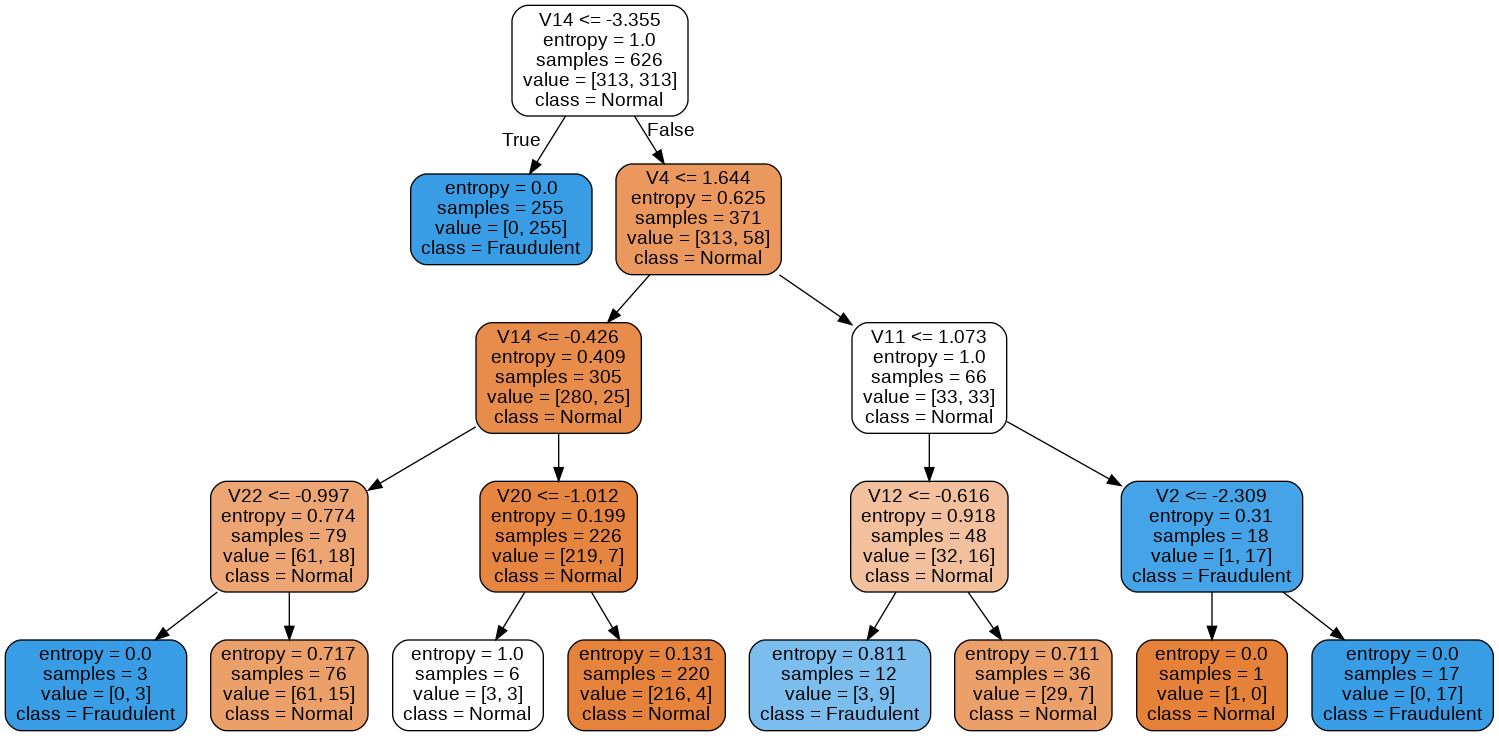

In [47]:
#plotting the Decision Tree

# creating the dot
dot = export_graphviz(dt_model, filled=True, rounded=True, feature_names=X.columns, class_names=["Normal", "Fraudulent"])

#plotting
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

Let´s check the same metrics for the model.

Classification Report for the Decision Tree Classifier: 

               precision    recall  f1-score   support

           0     0.9998    0.9613    0.9802     60417
           1     0.0387    0.8952    0.0741       105

    accuracy                         0.9612     60522
   macro avg     0.5192    0.9283    0.5271     60522
weighted avg     0.9981    0.9612    0.9786     60522

ROC Curve: 

 0.9283 



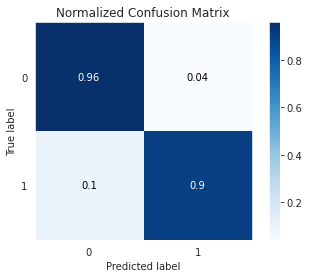

In [48]:
#Checking the metrics for the second model
print("Classification Report for the Decision Tree Classifier: \n\n", classification_report(y_val, y_pred, digits=4))

#ROC
print("ROC Curve: \n\n", round(roc_auc_score(y_val, y_pred),4), "\n")

#plotting the confusion matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True);

With the decision tree classifier, we had a slightly worse result than the Logistic Regression Model. We achieved an accuracy of 96%, correctly classifying 90% of fraudulent transactions, and 96% of normal transactions.

Let's validate our models with our test data.

## Validating the model 

 We should check the metrics against data that the model has not seen before to validate it. We will do that using the test data.

Let's first normalize the variables `Time` and `Amount` at the test data:

In [49]:
# normalizing test data

test_copy = test.copy()

std_scaler = StandardScaler()
test_copy["std_amount"] = std_scaler.fit_transform(test_copy.Amount.values.reshape(-1,1))
test_copy["std_time"] = std_scaler.fit_transform(test_copy.Time.values.reshape(-1,1))

test_copy.drop(["Amount", "Time"], axis=1, inplace=True)

test_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


Now let's split the data into the columns used to predict the class of the transaction (X) and the class itself (y).

In [62]:
#Splitting the data in X and y
X_test = test_copy.drop(["Class"],axis=1)
y_test = test_copy["Class"]

#Prediciting test data for Logisitic Regression model
y_pred = lr_model.predict(X_test)

Finally, let's check the accuracy and confusion matrix for the logistic regression model:

Classification Report for Logisitic Regression Model: 

               precision    recall  f1-score   support

           0     0.9999    0.9738    0.9866     42647
           1     0.0573    0.9189    0.1079        74

    accuracy                         0.9737     42721
   macro avg     0.5286    0.9464    0.5473     42721
weighted avg     0.9982    0.9737    0.9851     42721

ROC Curve: 

 0.9464 



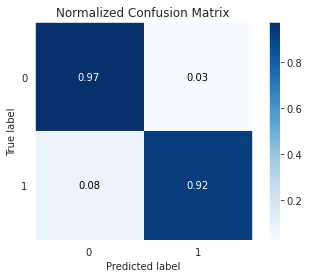

In [63]:
#Checking the metrics for the first model
print("Classification Report for Logisitic Regression Model: \n\n", classification_report(y_test, y_pred, digits=4))

#ROC
print("ROC Curve: \n\n", round(roc_auc_score(y_test, y_pred),4), "\n")

#plotting the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);

And run the same process for the Decision Tree Classifier model:

In [64]:
#prediciting data for the Decision Tree Model
y_pred = dt_model.predict(X_test)

Classification Report for the Decision Tree Classifier: 

               precision    recall  f1-score   support

           0     0.9998    0.9624    0.9807     42647
           1     0.0383    0.8649    0.0734        74

    accuracy                         0.9622     42721
   macro avg     0.5191    0.9136    0.5271     42721
weighted avg     0.9981    0.9622    0.9791     42721

ROC Curve: 

 0.9136 



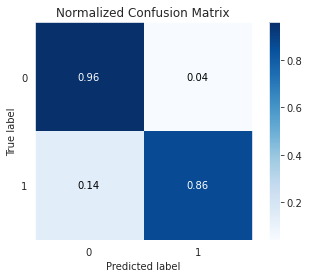

In [65]:
#Checking the metrics for the second model
print("Classification Report for the Decision Tree Classifier: \n\n", classification_report(y_test, y_pred, digits=4))

#ROC
print("ROC Curve: \n\n", round(roc_auc_score(y_test, y_pred),4), "\n")

#plotting the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);

Checking the metrics for both models:


| Metrics                 | Logistic Regression | Decision Tree |
|-------------------------|---------------------|---------------|
| Accuracy                | 0.97                | 0.96          |
| ROC Curve               | 0.94                | 0.91          |
| True Negatives (Normal) | 0.97                | 0.96          |
| True positives (Fraud)  | 0.92                | 0.86          |

The Logistic Regression model outperformed in all the metrics analyzed.

## Conclusion

Although the data had been previously treated and did not have missing values, we still had some work due to the Principal component Analysis done in some of the columns. Besides that, we had to choose a method to rebalance our training data, thus enhancing our model performance.

Analyzing the metrics for both the Logistic Regression Model and the Decision Tree Classifier Model, we could see that **the Logistic Regression Model Outperformed the Decision Tree classifier model in all the metrics analyzed.**

Although we already had a good performance with the logistic regression model, we could still enhance it by comparing it to other models and tuning the hyperparameters.